In [1]:
%matplotlib inline


import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import netCDF4
import pyugrid

print('pyugrid version: {}'.format(pyugrid.__version__))
print('netCDF4 version: {}'.format(netCDF4.__version__))

pyugrid version: 0.1.7
netCDF4 version: 1.2.2


In [2]:
url = ('http://comt.sura.org/thredds/dodsC/data/comt_1_archive/'
       'inundation_tropical/VIMS_SELFE/Hurricane_Ike_3D_final_run_with_waves')

ugrid = pyugrid.UGrid.from_ncfile(url)

The dataset has nodes (or vertexes) representing a point in a 2D space, the faces (or polygons) correspond to a plane enclosed by a set of
edges.  Note that the dataset does might not contain the edges! If that is the case ee need to compute those:

In [3]:
if not ugrid.edges:
    ugrid.build_edges()

Let's take a quick look at the mesh.

In [4]:
lon = ugrid.nodes[:, 0]
lat = ugrid.nodes[:, 1]
edges = ugrid.edges[:]
triangles = ugrid.faces[:]

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

/home/filipe/miniconda3/envs/IOOS/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


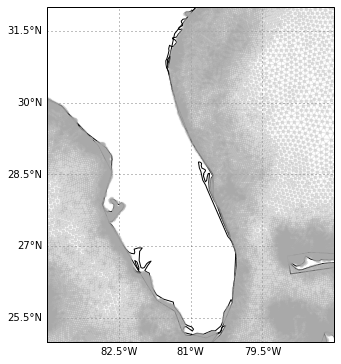

In [6]:
fig, ax = make_map()

kw = dict(marker='.', linestyle='-', alpha=0.25, color='darkgray')
ax.triplot(lon, lat, triangles, **kw)
ax.coastlines()
ax.set_extent([-84, -78, 25, 32])

Let's try to find the point nearest to one of the SECOORA buoys in the dataset.

In [7]:
duck = [-75.51997, 35.8112]

In [8]:
duck_face = ugrid.locate_face_simple(duck)

print(duck_face)

848669


Now let's test the face-face connectivity array or the neighbors of each triangle.

The connectivity array can be extremely useful when searching for the shortest path between to grid points.

In [9]:
if not ugrid.face_face_connectivity:
    ugrid.build_face_face_connectivity()

In [10]:
neighbors = ugrid.face_face_connectivity[duck_face]
neighbors

array([848668,     -1, 848670], dtype=int32)

This triangle has only two neighbors. How about finding the nodes?

In [11]:
duck_node = ugrid.locate_nodes(duck)
duck_node

84777

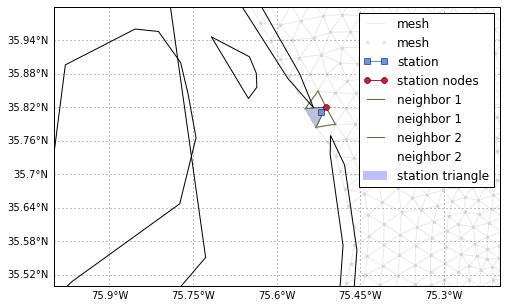

In [12]:
fig, ax = make_map()

def plot_triangle(face, label, **kw):
    ax.triplot(lon[triangles[face]],
               lat[triangles[face]],
               triangles=triangles[face], label=label, **kw)

ax.triplot(lon, lat, triangles, label='mesh', **kw)
ax.plot(duck[0], duck[1], color='cornflowerblue',
        label='station', marker='s', zorder=2)
ax.plot(lon[duck_node], lat[duck_node], color='crimson',
        label='station nodes', marker='o', zorder=2)

ax.tripcolor(lon[triangles[duck_face]],
             lat[triangles[duck_face]],
             triangles[duck_face],
             label='station triangle',
             facecolors=np.array([1]), alpha=0.25, zorder=1)

plot_triangle(neighbors[0], color='darkolivegreen', label='neighbor 1', zorder=1)
plot_triangle(neighbors[-1], color='darkolivegreen', label='neighbor 2', zorder=1)

ax.coastlines()
ax.set_extent([-76, -75.2, 35.5, 36])
leg = ax.legend()  # Maplotlib's Tri-Plotting legend needs some work!